# Project Report

Here I will explain the steps I took to solve the problem and the reasoning behind them. First things first, I first tried to plot the time series data to see if there is any pattern in the data. I used the following code to plot the data.


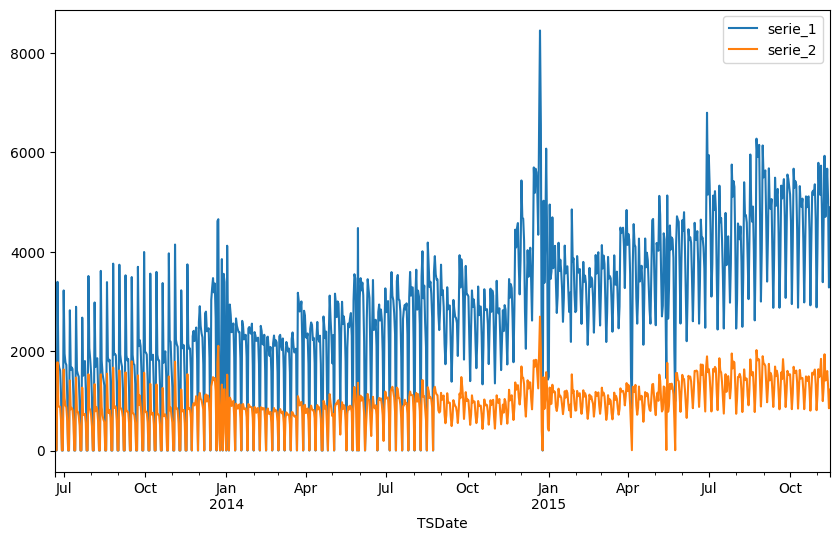

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import os
from dotenv import load_dotenv
load_dotenv()

PATH_FOR_TRAIN = os.getenv('PATH_FOR_TRAIN')

df = pd.read_csv(PATH_FOR_TRAIN, index_col='TSDate', parse_dates=['TSDate'])

#plot two figures in one, based on column serieNames (serie_1, serie_2) and vlaues of sales
fig, ax = plt.subplots(figsize=(10, 6))
df[df['serieNames'] == 'serie_1']['sales'].plot(ax=ax, label='serie_1')
df[df['serieNames'] == 'serie_2']['sales'].plot(ax=ax, label='serie_2')
plt.legend()

## we have many ziro values in 
The explanation of the ziros (without any other explanation at hand) from opinion could be due to two reasons:
1. **Stock out**: We may had stock out of the product in 2013 that every Saturday we had no sales. On ther hand once the value for serie_1 is 0, the value of sale for serie_2 is always 5, showing a significant correlation between the two series (Correlation of 0.94 from the upcoming models). In this case serie_2 could be seen as a complementary product, low sales of one could trigger a fixed demand for the other.
2. **Promotion**: A promotion might ensure a minimum fixed sale (e.g., 5) for serie_2 when serie_1 fails to sell.
3. **Data Artifact**: Based on a threshold if we have ziro in serie_1, the system assume 5 for the other one. 

To address the issue, we can test all the scenarios below and see which one makes better results, but due to limited time and limited information I have from the sales data, I will only test one of them. 
1. **Consider them as missing data**: We can consider the ziro values as missing data and use imputation techniques to fill them. If for example we imput the as mean, then we are predicting **demand** and not sales (e.g., demand cannot be ziro). 
2. **Remove them**: We can remove the ziro values from the data. But this leads to loose lot of information.
3. **Remove only weekends with ziro values**: This is also not viable becuase it breaks the temporal dependency in time series elements and also deprive the model in predicting weekend sales.
4.**Segmntation**: Segmenting data into subsets (e.g., weekend vs. weekday behavior) can also work, but it has limitations:
    - Segmented models require separate training and testing, which may not generalize well across all time series.
    - Managing and combining predictions from multiple models for 55,000 time series could increase complexity.
5. **Use a model that can handle missing data and doing feature engineering**: This is the option that i selected to continue with. By creating augmented features we can still inform the model from the ziro values but also keeping the temporal dependency in the data. And we know certaing type of model are more robust to missing data. 




To properly model the problem, I put the data on a data ware house on Snowflake and I made a database and a table inside it for **data ingesiton purposes**. 

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import warnings

warnings.filterwarnings("ignore")

# Function for time-series analysis plot
def tsplot(y, lags=None, title="Time Series Analysis", figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title(f'{title}\n Dickey-Fuller: p={p_value:.5f}')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()
    plt.show()






In [15]:
import pandas as pd
import os
from dotenv import load_dotenv
load_dotenv()
PATH_FOR_TRAIN = os.getenv('PATH_FOR_TRAIN')

df = pd.read_csv(PATH_FOR_TRAIN, index_col='TSDate', parse_dates=['TSDate'])

Time Series Analysis for Serie 1


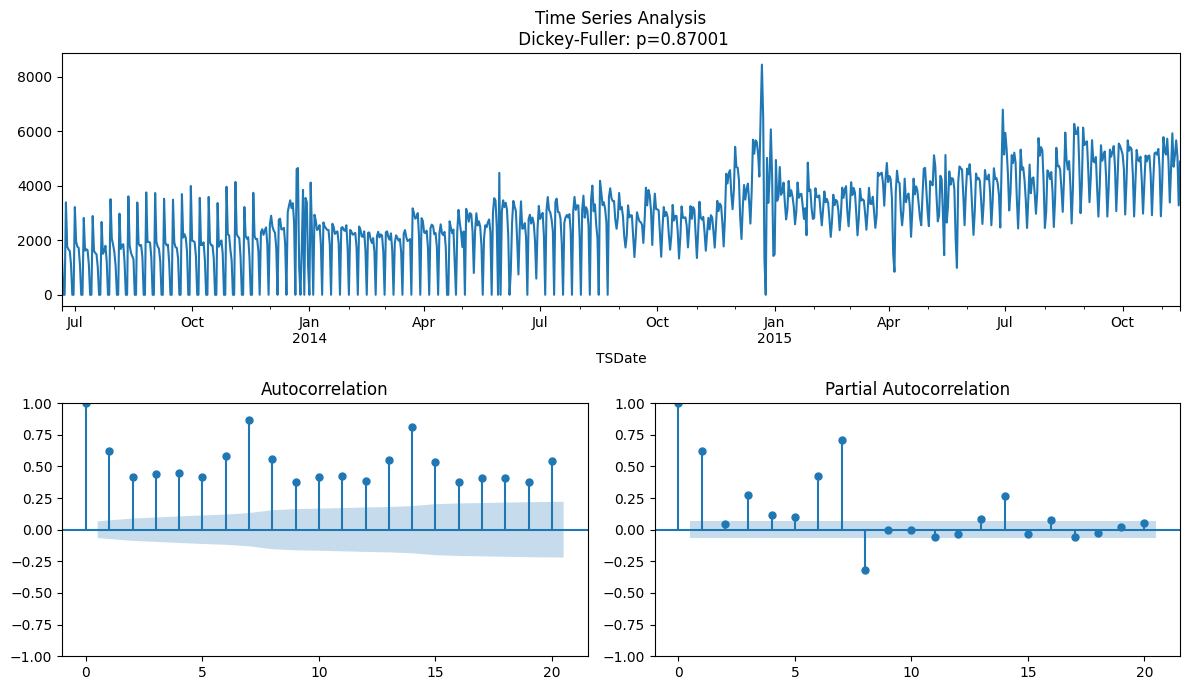

Time Series Analysis for Serie 2


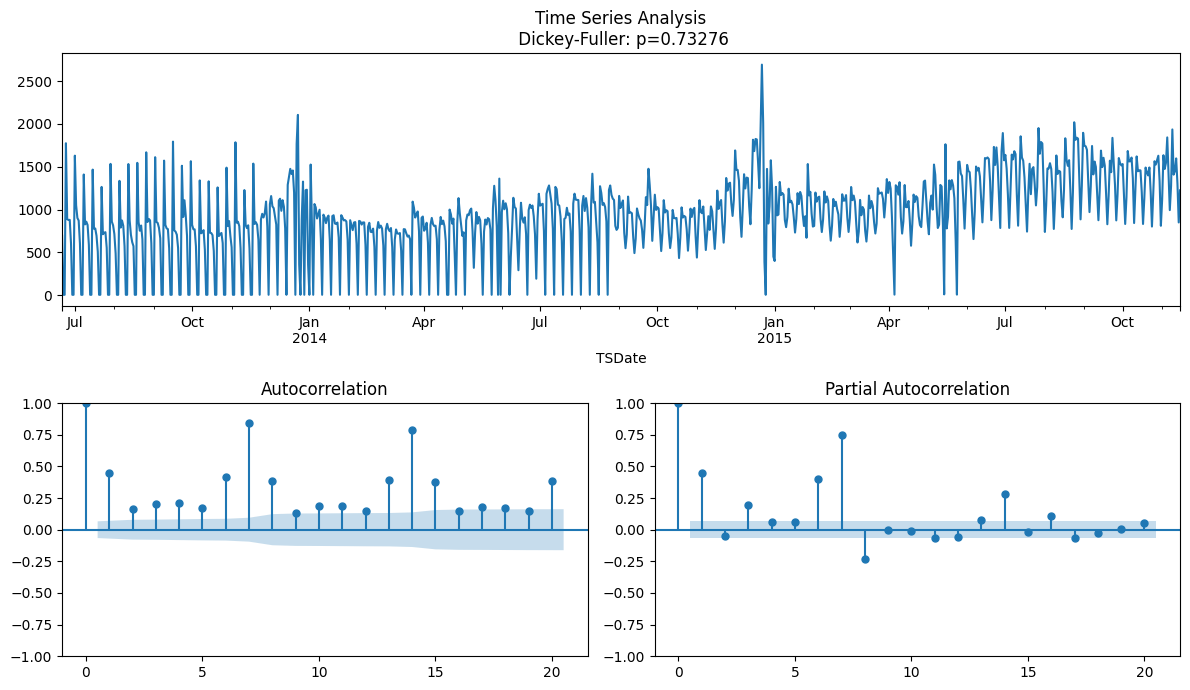

In [17]:
# Perform time-series analysis for each serie
# Split the time-series into two based on 'serieNames'
serie_1 = df[df['serieNames'] == 'serie_1']['sales']
serie_2 = df[df['serieNames'] == 'serie_2']['sales']


print("Time Series Analysis for Serie 1")
tsplot(serie_1.dropna(), lags=20)

print("Time Series Analysis for Serie 2")
tsplot(serie_2.dropna(), lags=20)

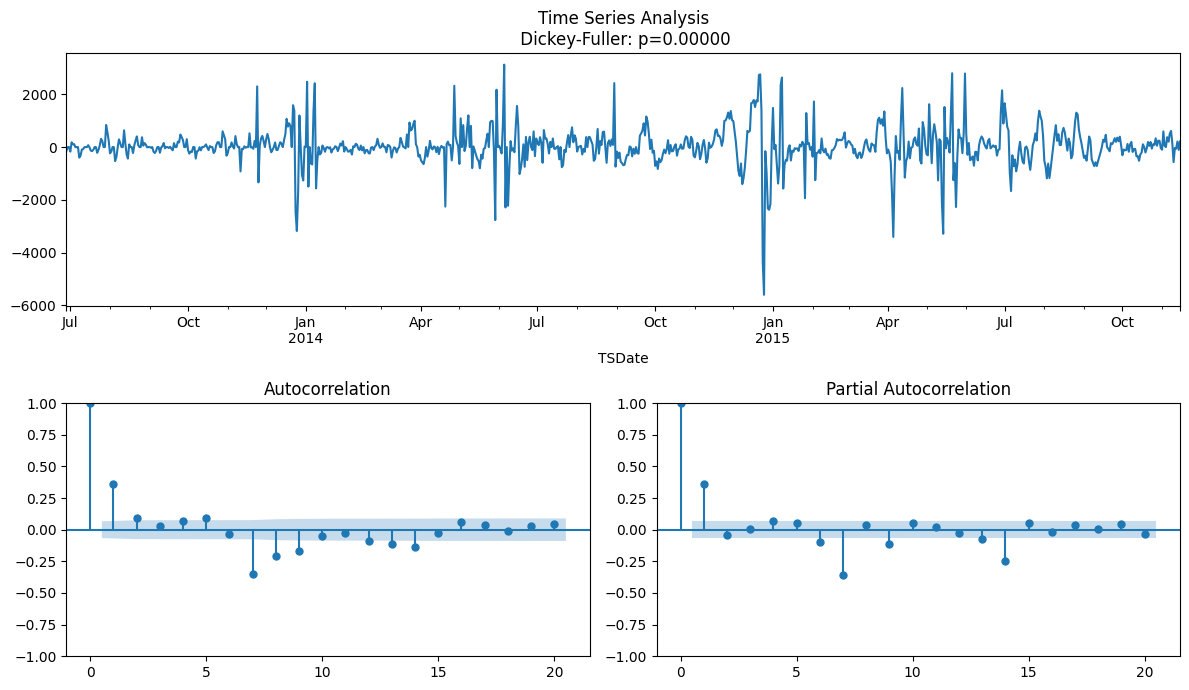

In [24]:
serie_1_diff = (serie_1 - serie_1.shift(7)).dropna()
tsplot(serie_1_diff.dropna(), lags=20)



In [22]:
from TSForecasting.utils.main_utils.utils import load_object, load_numpy_array_data
import pandas as pd

chosen_model = load_object("final_model/model.pkl")
import os
df_test = load_numpy_array_data("/Users/Moaze002/Documents/cl_project/Artifacts/12_17_2024_21_42_53/data_transformation/transformed/test.npy")
template = pd.read_csv("/Users/Moaze002/Documents/cl_project/TSdata/test.csv")

<_io.BufferedReader name='final_model/model.pkl'>


In [23]:
x_test, y_test =   df_test[:, 1:-1], df_test[:, -1]

In [24]:
len(x_test)

30

In [25]:
template['sales'] = chosen_model.predict(x_test)

In [26]:
template

,TSDate,serieNames,sales
0,2015-11-16,serie_2,1632.000000
1,2015-11-16,serie_1,4693.968254
2,2015-11-17,serie_1,4572.313131
3,2015-11-17,serie_2,1263.546875
4,2015-11-18,serie_1,4613.520930
5,2015-11-18,serie_2,1391.102941
6,2015-11-19,serie_1,4668.352941
7,2015-11-19,serie_2,1619.641509
8,2015-11-20,serie_2,1143.294643
9,2015-11-20,serie_1,4539.441667


<Axes: >

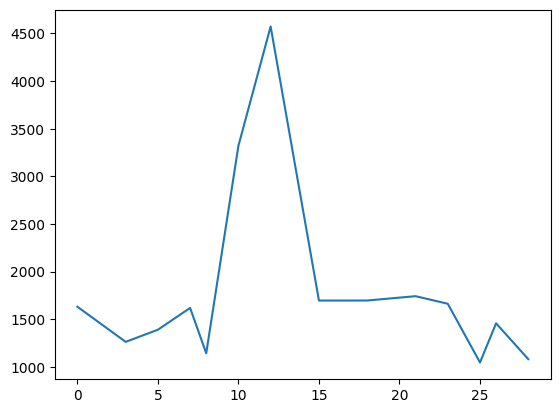

In [28]:
template[template['serieNames'] == 'serie_2']['sales'].plot()